# **Driver Drowsiness Detection**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm

In [ ]:
train_dir = '/content/drive/MyDrive/dataset_new/train/'
test_dir = '/content/drive/MyDrive/dataset_new/test/'

In [ ]:
def load_images(directory):
    images = []
    labels = []

    for category in os.listdir(directory):
        for filename in tqdm(os.listdir(os.path.join(directory, category))):
            image_path = os.path.join(directory, category, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(category)

    images = np.array(images, dtype='float32')
    return images, labels

In [ ]:
train_images, train_labels = load_images(train_dir)

100%|██████████| 617/617 [00:11<00:00, 53.34it/s] 


In [ ]:
test_images, test_labels = load_images(test_dir)

100%|██████████| 106/106 [00:02<00:00, 48.30it/s]


In [ ]:
x_train, y_train = load_images(train_dir)
x_test, y_test = load_images(test_dir)

100%|██████████| 106/106 [00:01<00:00, 104.25it/s]


In [ ]:
x_train = x_train / 255.
x_test = x_test / 255.

In [ ]:
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
cnn = Sequential()

cnn.add(Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=(224,224,3)))
cnn.add(MaxPooling2D(pool_size=2))

cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu',padding='same'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))

cnn.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(units=128,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

cnn.add(Dense(units=4,activation='softmax'))

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 32)       128       
 ormalization)                                                   
                                                        

In [ ]:
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20,mode='max',verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=5,mode='max',verbose=1,factor=0.1,min_lr=0.001)
checkpoint_filename = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True,mode='max')

r = cnn.fit(x=x_train,
            y=y_train,
            epochs=20,
            batch_size=32,
            validation_data=(x_test,y_test),
            callbacks=[early_stopping,reduce_lr,model_checkpoint])

Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7491
Epoch 1: val_accuracy improved from -inf to 0.25173, saving model to checkpoint/
78/78 [==============================] - 190s 2s/step - loss: 0.5745 - accuracy: 0.7491 - val_loss: 4.5052 - val_accuracy: 0.2517 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.8030
Epoch 2: val_accuracy did not improve from 0.25173
78/78 [==============================] - 179s 2s/step - loss: 0.4040 - accuracy: 0.8030 - val_loss: 5.2593 - val_accuracy: 0.2517 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8452
Epoch 3: val_accuracy improved from 0.25173 to 0.47806, saving model to checkpoint/
78/78 [==============================] - 180s 2s/step - loss: 0.3429 - accuracy: 0.8452 - val_loss: 4.0444 - val_accuracy: 0.4781 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - ETA: 0s - loss: 0.291

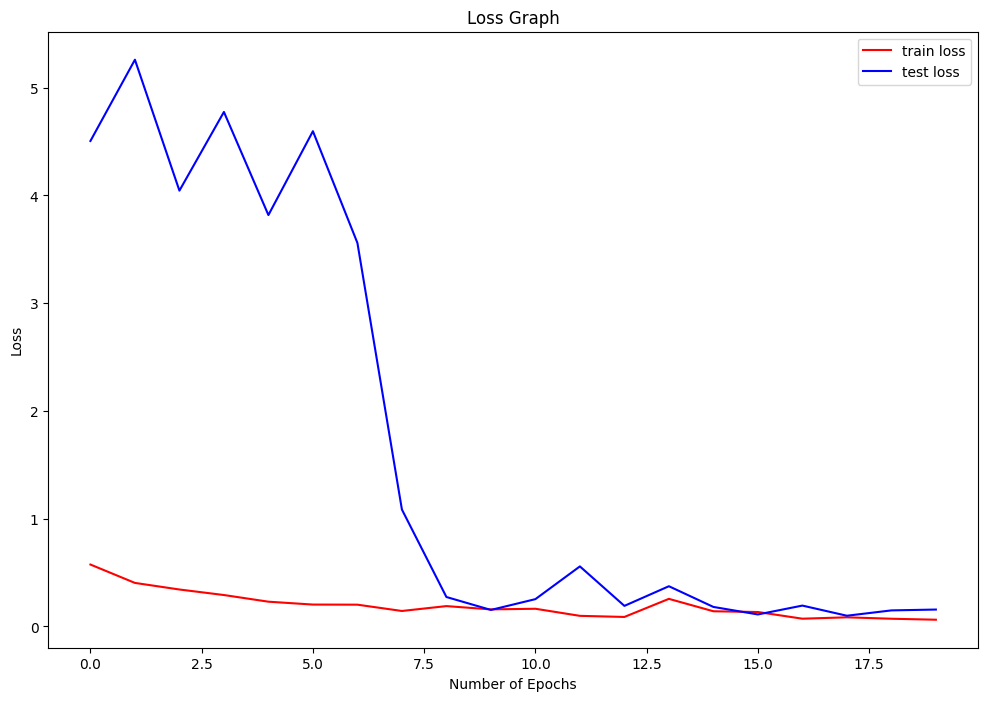

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

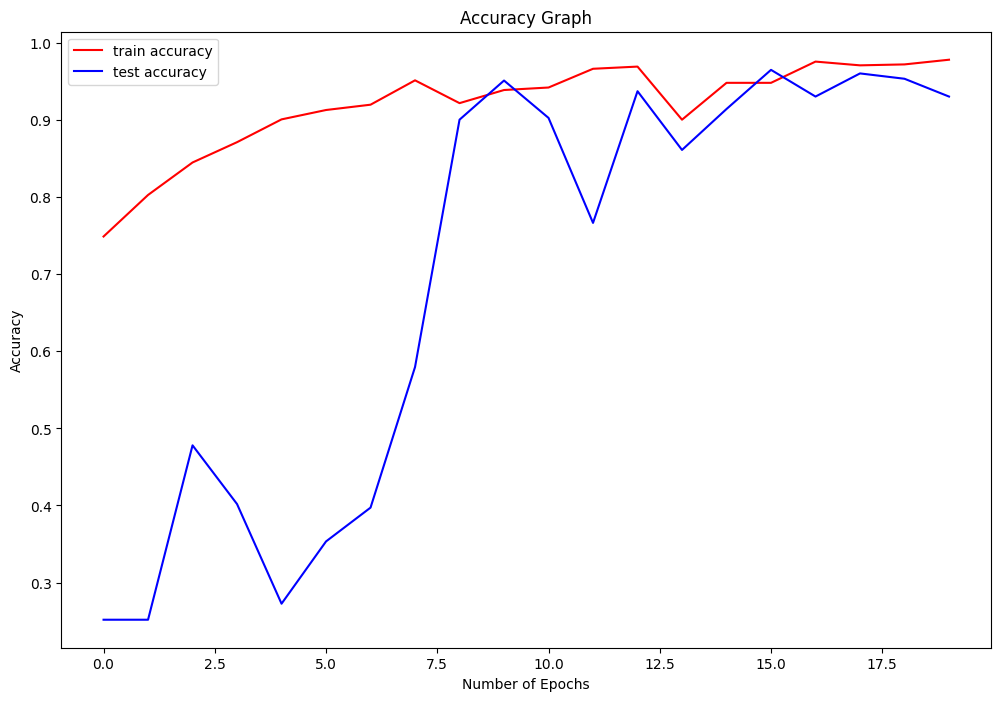

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
cnn.save(filepath='drowsiness_detector.model',save_format='h5')
model = load_model(filepath='drowsiness_detector.model')
model

In [ ]:
scores=model.evaluate(x_train, y_train)

78/78 [==============================] - 49s 603ms/step - loss: 0.0823 - accuracy: 0.9720


In [ ]:
print(scores)

[0.0823216587305069, 0.9720308184623718]


In [ ]:
history

scores=model.evaluate(x_train)
scores=cnn.evaluate(x_train)
from google.colab import drive
drive.mount('/content/drive')
import cv2
import os
import numpy as np
from tqdm import tqdm
train_dir = '/content/drive/MyDrive/dataset_new/train/'
test_dir = '/content/drive/MyDrive/dataset_new/test/'
def load_images(directory):
    images = []
    labels = []

    for category in os.listdir(directory):
        for filename in tqdm(os.listdir(os.path.join(directory, category))):
            image_path = os.path.join(directory, category, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(category)

    images = np.array(images, dtype='float32')
    return images, labels
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)
x_train, y_train = load_images(train_dir)
x_test, y_test = lo

14/14 [==============================] - 17s 1s/step


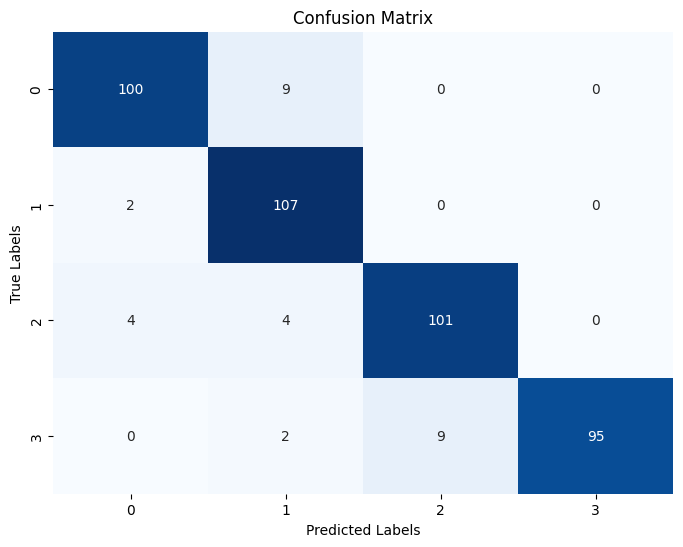

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = cnn.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_labels, y_pred_labels, average='macro')
recall = recall_score(y_true_labels, y_pred_labels, average='macro')
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))


Precision: 0.9347
Recall: 0.9305
F1-score: 0.9311


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9307


In [ ]:
epoch_accuracies = []  # List to store accuracy of each epoch

# Loop over 20 epochs
for epoch in range(20):
    # Perform training and evaluation for the current epoch
    # ...

    # Calculate accuracy for the current epoch
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    epoch_accuracies.append(accuracy)  # Append accuracy to the list

# Calculate the average accuracy
average_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)

print("Average Accuracy: {:.4f}".format(average_accuracy))


Average Accuracy: 0.9307
